In [137]:
import pandas as pd
import numpy as np

data = "./car_soh_data.csv"
df = pd.read_csv(data)

In [138]:
# df.head(5)
df.describe()

,model_year,battery_capacity_kWh,electric_range_km_reported,power_kW,top_speed_kmh,mileage_km,price_eur,soh
count,335.000000,335.000000,335.000000,321.000000,332.000000,335.000000,335.000000,335.000000
mean,2021.689552,70.595821,444.546269,202.618380,175.677711,76785.074627,28433.641791,93.821493
std,1.657602,18.172666,106.128623,91.317022,29.664515,40165.768985,11339.220627,3.529230
min,2015.000000,1.000000,1.000000,1.000000,20.000000,1000.000000,5790.000000,76.100000
25%,2021.000000,62.000000,400.000000,150.000000,160.000000,48500.000000,20885.000000,92.050000
50%,2022.000000,77.000000,460.000000,170.000000,160.000000,71000.000000,28190.000000,94.200000
75%,2023.000000,82.000000,515.000000,258.000000,190.750000,102000.000000,33585.000000,96.200000
max,2025.000000,112.000000,668.000000,585.000000,261.000000,227000.000000,85780.000000,101.200000


In [ ]:
# sample = df.sample(1).iloc[0]
# sample
df = df[df["vehicle_type"] == "PASSENGER_CAR"] # just passenger cars
len(df)
df["manufacturer"].value_counts()


manufacturer
Volkswagen       74
Tesla            35
Skoda            29
Polestar         24
BMW              23
Mercedes-Benz    22
Audi             19
Volvo            15
Hyundai          14
Kia              13
Opel             11
Nissan           10
Peugeot           9
Renault           8
MG                6
Toyota            3
Citroen           3
Ford              3
Porsche           2
Mini              2
Cupra             1
Subaru            1
Maxus             1
Seat              1
Dacia             1
Jaguar            1
Name: count, dtype: int64

In [140]:
df = df.copy()
df["workdays"] = (pd.to_datetime(df["purchase_date"]) - pd.to_datetime(df["first_usage_date"])).dt.days

In [141]:
df_analysis = df[["manufacturer", "manufacturer_and_model", "battery_capacity_kWh", "model_year", "workdays", "mileage_km", "soh"]]
df_analysis.head(5)

,manufacturer,manufacturer_and_model,battery_capacity_kWh,model_year,workdays,mileage_km,soh
0,Kia,Kia EV6,77.0,2022,1133,23000,98.1
1,Skoda,Skoda Enyaq,82.0,2022,1350,151000,90.7
2,Citroen,Citroen C4,50.0,2022,1186,35000,94.0
3,Kia,Kia EV9,99.8,2024,514,38000,98.8
4,Mercedes-Benz,Mercedes-Benz EQV,100.0,2022,1349,87000,97.3


In [142]:
df_analysis = df_analysis.copy()
degradation = 100 - df_analysis["soh"]
df_analysis.loc[:, "degradation"] = degradation
# df_analysis["deg_per_1000km"] = (degradation / df_analysis["mileage_km"]) * 1000
df_analysis["deg_per_20000km"] = (degradation / df_analysis["mileage_km"]) * 20000
df_analysis["deg_per_365days"] = (degradation / df_analysis["workdays"]) * 365
df_analysis.head(5)

,manufacturer,manufacturer_and_model,battery_capacity_kWh,model_year,workdays,mileage_km,soh,degradation,deg_per_20000km,deg_per_365days
0,Kia,Kia EV6,77.0,2022,1133,23000,98.1,1.9,1.652174,0.612092
1,Skoda,Skoda Enyaq,82.0,2022,1350,151000,90.7,9.3,1.231788,2.514444
2,Citroen,Citroen C4,50.0,2022,1186,35000,94.0,6.0,3.428571,1.846543
3,Kia,Kia EV9,99.8,2024,514,38000,98.8,1.2,0.631579,0.852140
4,Mercedes-Benz,Mercedes-Benz EQV,100.0,2022,1349,87000,97.3,2.7,0.620690,0.730541


In [143]:
df_mean_deg = df_analysis.copy()
mean = df_mean_deg.groupby("manufacturer_and_model")["deg_per_20000km"].mean().reset_index()
mean

,manufacturer_and_model,deg_per_20000km
0,Audi Q4 e-tron,1.686403
1,Audi Q8 e-tron,1.068966
2,Audi e-tron,1.459804
3,BMW i3,3.717089
4,BMW i4,1.042385
...,...,...
68,Volkswagen ID.7,1.319588
69,Volkswagen Up!,4.271207
70,Volkswagen e-up!,2.705036
71,Volvo C40,1.395097


Text(0.5, 0, 'Mileage (km)')

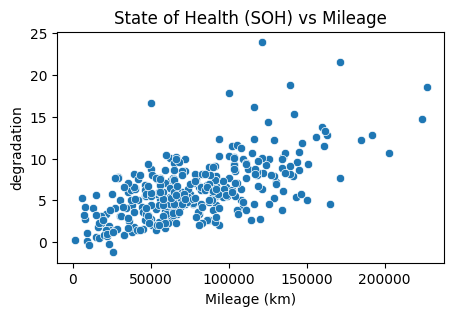

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 3))
sns.scatterplot(data=df_analysis, x="mileage_km", y="degradation")
plt.title("State of Health (SOH) vs Mileage")
plt.xlabel("Mileage (km)")

Text(0.5, 0, 'Time (days)')

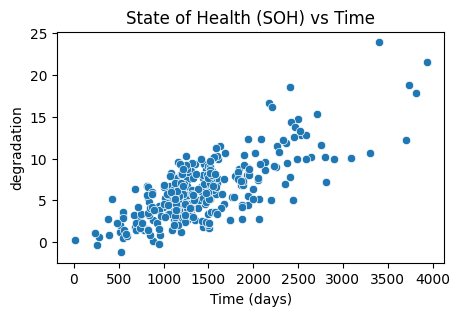

In [145]:
plt.figure(figsize=(5, 3))
sns.scatterplot(data=df_analysis, x="workdays", y="degradation")
plt.title("State of Health (SOH) vs Time")
plt.xlabel("Time (days)")

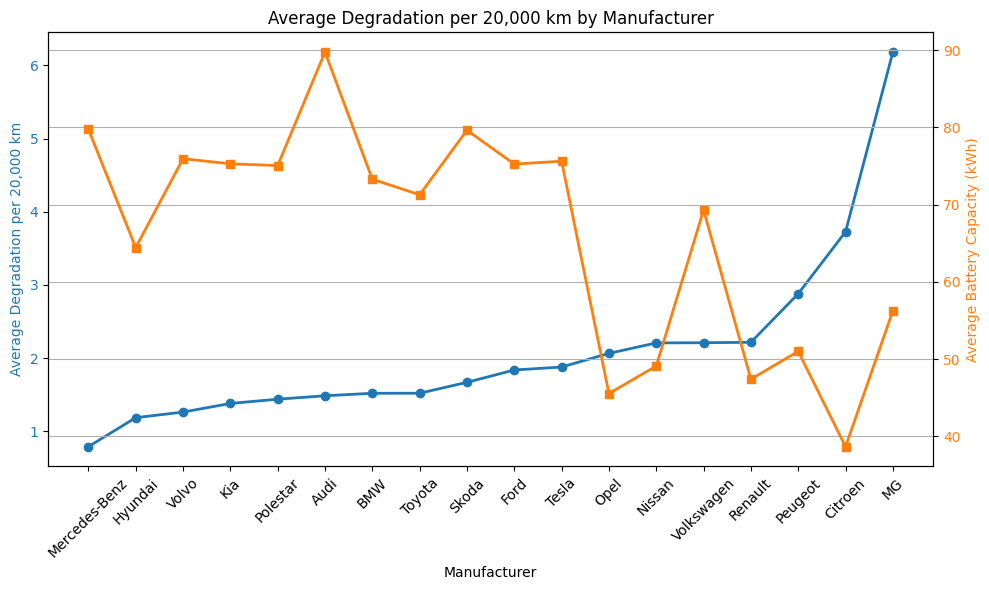

In [155]:
df_analysis_manufacturer = df_analysis.copy()

df_analysis_bymanufacturer = (
    df_analysis.groupby("manufacturer", observed=False)
    .agg(
        avg_degradation_per_20000km=("deg_per_20000km", "mean"),
        avg_battery_capacity_kWh=("battery_capacity_kWh", "mean"),
        # avg_degradation_per_365days=("deg_per_365days", "mean"),
        # count=("deg_per_20000km", "size"),
    )
    .reset_index()
)

df_analysis_bymanufacturer = df_analysis_bymanufacturer[df_analysis_bymanufacturer["manufacturer"].map(df_analysis["manufacturer"].value_counts()) >= 3]

df_analysis_bymanufacturer_sorted = df_analysis_bymanufacturer.sort_values("avg_degradation_per_20000km", ascending=True)
plt.figure(figsize=(10, 6))

ax1 = plt.gca()
ax1.plot(df_analysis_bymanufacturer_sorted["manufacturer"], df_analysis_bymanufacturer_sorted["avg_degradation_per_20000km"], marker='o', linewidth=2, markersize=6, color='tab:blue', label='Degradation')
ax1.set_title("Average Degradation per 20,000 km by Manufacturer")
ax1.set_xlabel("Manufacturer")
ax1.set_ylabel("Average Degradation per 20,000 km", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()
ax2.plot(df_analysis_bymanufacturer_sorted["manufacturer"], df_analysis_bymanufacturer_sorted["avg_battery_capacity_kWh"], marker='s', linewidth=2, markersize=6, color='tab:orange', label='Battery Capacity')
ax2.set_ylabel("Average Battery Capacity (kWh)", color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.grid()
plt.tight_layout()

**LightGBM

In [157]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

df_analysis["manufacturer_and_model"] = (
    df_analysis["manufacturer_and_model"].astype("category")
)

X = df_analysis[[
    "manufacturer_and_model",
    "battery_capacity_kWh",
    "model_year",
    "workdays",
    "mileage_km",
]].copy()

y = df_analysis["soh"]

df_analysis["manufacturer_and_model"] = df_analysis["manufacturer_and_model"].astype("category")
cat_features = ["manufacturer_and_model"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = lgb.LGBMRegressor(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=3,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=-1
)

model.fit(X_train, y_train, categorical_feature=cat_features)

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,3
,learning_rate,0.05
,n_estimators,150
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [148]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

MAE: 1.719862986507063
R2: 0.6101720098054355
RMSE: 2.1881470218986885


In [149]:
from sklearn.model_selection import KFold, cross_val_score

cv = KFold(n_splits=5, shuffle=True, random_state=42)

mae_scores = cross_val_score(
    model, X, y,
    cv=cv,
    scoring="neg_mean_absolute_error"
)

print("CV MAE:", -mae_scores.mean())


CV MAE: 1.5826104966853034


<Figure size 1000x600 with 0 Axes>

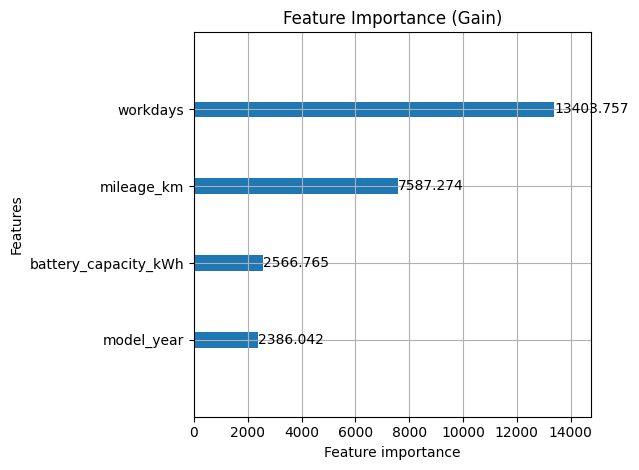

In [158]:
# Plot feature importance
plt.figure(figsize=(10, 6))
lgb.plot_importance(model, max_num_features=10, importance_type='gain')
plt.title("Feature Importance (Gain)")
plt.tight_layout()
plt.show()

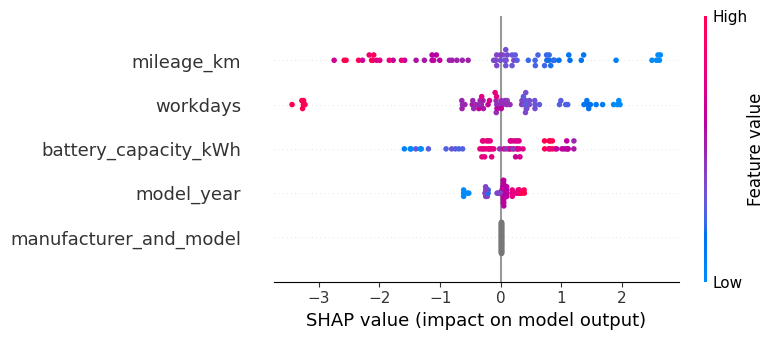

In [ ]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)


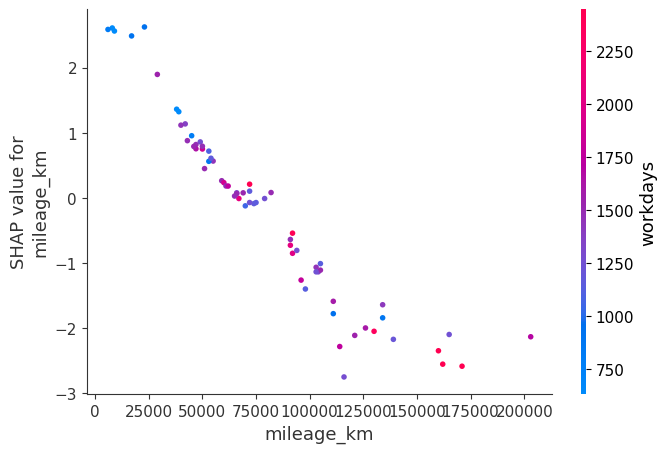

In [ ]:
shap.dependence_plot(
    "mileage_km",
    shap_values,
    X_test
)
